In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

510285


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20240401-Merscope01_s11_n1200'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation
/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed


In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna
-- 9 folders, 221 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Analysis/color_usage.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H8M9'} 477


# Run segmentation

In [9]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [10]:
from importlib import reload

In [11]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [21]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)
        
        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1200/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )        
    

Segmentation label file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_0.npy already exists, skip
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_001.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.123s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_001_processed.hdf5
-- all used channe

-- corrected warp for channel 637 in 8.633s.
- Finished warp correction in 8.633s.
- apply microscope corrections
- run Cellpose segmentation in 35.254s.
- save to 91 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_5.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_006.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_006.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_006.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_006_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.525s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_006.d

- run Cellpose segmentation in 38.567s.
- save to 159 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_10.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_011.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_011.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_011.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_011_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.100s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_011.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_011_processe

- run Cellpose segmentation in 48.386s.
- save to 288 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_15.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_016.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_016.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_016_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.269s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_016_processe

- run Cellpose segmentation in 32.749s.
- save to 54 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_20.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_021.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_021.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_021.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_021_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.179s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_021.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_021_processed

-- corrected warp for channel 637 in 8.645s.
- Finished warp correction in 8.645s.
- apply microscope corrections
- run Cellpose segmentation in 43.799s.
- save to 250 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_30.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_031.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_031.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_031_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.073s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_031

-- corrected warp for channel 637 in 8.677s.
- Finished warp correction in 8.677s.
- apply microscope corrections
- run Cellpose segmentation in 49.371s.
- save to 250 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_35.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_036.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_036.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_036.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_036_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.789s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_036

-- corrected warp for channel 637 in 8.916s.
- Finished warp correction in 8.916s.
- apply microscope corrections
- run Cellpose segmentation in 53.118s.
- save to 255 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_40.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_041.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_041.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_041.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_041_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.919s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_041

-- drift 2: [-0.01  3.53  8.16] in 0.410s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.811s.
- Finished warp correction in 8.811s.
- apply microscope corrections
- run Cellpose segmentation in 46.337s.
- save to 202 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_45.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_046.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_046.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_046.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_046_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single ima

- Loaded images for channels:['637', '477'] in 0.971s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  4.020e+00  1.051e+01] in 0.632s.
-- drift 1: [-0.02  4.34 10.36] in 0.530s.
-- drift 2: [-0.06  4.23 10.73] in 0.481s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.711s.
- Finished warp correction in 8.711s.
- apply microscope corrections
- run Cellpose segmentation in 34.760s.
- save to 22 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_50.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_051.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_051.dax
Initialize DaxProcesser for file:/lab/

- Loaded images for channels:['637', '477'] in 1.209s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  5.09  9.46] in 0.562s.
-- drift 1: [-0.04  4.88  9.42] in 0.479s.
-- drift 2: [-0.03  4.86  9.53] in 0.489s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.236s.
- Finished warp correction in 9.237s.
- apply microscope corrections
- run Cellpose segmentation in 52.473s.
- save to 252 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_55.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_056.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_056.dax
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['637', '477'] in 1.165s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   3.81 9.49] in 0.532s.
-- drift 1: [-0.01  3.58  9.55] in 0.488s.
-- drift 2: [0.   3.63 9.53] in 0.495s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.948s.
- Finished warp correction in 8.948s.
- apply microscope corrections
- run Cellpose segmentation in 52.151s.
- save to 216 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_61.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_062.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_062.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puz

- Loaded images for channels:['637', '477'] in 1.035s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  2.91  9.37] in 0.521s.
-- drift 1: [-0.01  2.8   9.37] in 0.484s.
-- drift 2: [-0.02  2.82  9.41] in 0.461s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.903s.
- Finished warp correction in 8.904s.
- apply microscope corrections
- run Cellpose segmentation in 49.493s.
- save to 248 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_66.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_067.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_067.dax
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['637', '477'] in 1.041s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [1.00e-02 4.41e+00 1.03e+01] in 0.558s.
-- drift 1: [-1.000e-02  4.380e+00  1.062e+01] in 0.508s.
-- drift 2: [-0.02  4.23 10.56] in 0.504s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.058s.
- Finished warp correction in 9.058s.
- apply microscope corrections
- run Cellpose segmentation in 38.140s.
- save to 101 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_71.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_072.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_072.dax
Initialize DaxProcesser for 

- Loaded images for channels:['637', '477'] in 1.001s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.28  8.75] in 0.556s.
-- drift 1: [-0.03  4.48  8.68] in 0.492s.
-- drift 2: [-0.02  4.51  8.75] in 0.492s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.910s.
- Finished warp correction in 8.910s.
- apply microscope corrections
- run Cellpose segmentation in 50.157s.
- save to 208 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_76.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_077.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_077.dax
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['637', '477'] in 1.077s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  3.14  8.79] in 0.477s.
-- drift 1: [-0.01  3.22  8.61] in 0.442s.
-- drift 2: [-0.02  2.98  8.85] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.901s.
- Finished warp correction in 8.901s.
- apply microscope corrections
- run Cellpose segmentation in 42.781s.
- save to 149 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_81.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_082.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_082.dax
Initialize DaxProcesser for file:/lab/weissman_imagi

- Loaded images for channels:['637', '477'] in 1.282s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    3.49 10.29] in 0.634s.
-- drift 1: [ 0.    3.37 10.09] in 0.531s.
-- drift 2: [-1.000e-02  3.300e+00  1.019e+01] in 0.510s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.008s.
- Finished warp correction in 9.009s.
- apply microscope corrections
- run Cellpose segmentation in 47.235s.
- save to 176 labels to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_86.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_087.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_087.dax
Initialize DaxProcesser for file:/lab

- Loaded images for channels:['477', '405'] in 2.051s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_091.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_091_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.065s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  4.45  9.55] in 0.556s.
-- drift 1: [-0.01  4.68  9.11] in 0.477s.
-- drift 2: [-0.01  4.32  9.62] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.855s.
- Finished warp correction in 8.855s.
- apply microscope corrections
- run Cellpose segmentation in 35.020s.
- save to 75 labels to file: /la

- Loaded images for channels:['477', '405'] in 1.893s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_096.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_096_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.954s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.09  9.8 ] in 0.556s.
-- drift 1: [-0.01  4.02  9.65] in 0.492s.
-- drift 2: [-0.01  3.93  9.74] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.913s.
- Finished warp correction in 8.913s.
- apply microscope corrections
- run Cellpose segmentation in 54.445s.
- save to 256 labels to file: /l

- Loaded images for channels:['477', '405'] in 2.055s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_101.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_101_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.337s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  3.250e+00  1.096e+01] in 0.519s.
-- drift 1: [-1.000e-02  3.140e+00  1.093e+01] in 0.478s.
-- drift 2: [-0.03  3.05 10.88] in 0.465s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.903s.
- Finished warp correction in 8.903s.
- apply microscope corrections
- run Cellpose segmentation in 49.244s.
- 

- Loaded images for channels:['477', '405'] in 2.039s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_106.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_106_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.363s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.350e+00  1.109e+01] in 0.540s.
-- drift 1: [-1.000e-02  2.290e+00  1.098e+01] in 0.481s.
-- drift 2: [-1.000e-02  2.250e+00  1.107e+01] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.869s.
- Finished warp correction in 8.869s.
- apply microscope corrections
- run Cellpose segmentation

- Loaded images for channels:['477', '405'] in 1.924s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_111.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_111_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.989s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  2.66  8.94] in 0.638s.
-- drift 1: [0.   2.67 8.75] in 0.462s.
-- drift 2: [-0.01  2.47  9.16] in 0.493s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.574s.
- Finished warp correction in 9.574s.
- apply microscope corrections
- run Cellpose segmentation in 38.763s.
- save to 134 labels to file: /lab/

- Loaded images for channels:['477', '405'] in 1.752s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_116.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_116_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.003s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.48 10.36] in 0.544s.
-- drift 1: [-1.000e-02  4.380e+00  1.035e+01] in 0.484s.
-- drift 2: [-1.000e-02  4.330e+00  1.037e+01] in 0.489s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.904s.
- Finished warp correction in 8.904s.
- apply microscope corrections
- run Cellpose segmentation in 53.137s.
- 

- Loaded images for channels:['477', '405'] in 1.708s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_121.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_121_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.167s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    4.16 10.02] in 0.532s.
-- drift 1: [-0.01  3.98  9.9 ] in 0.480s.
-- drift 2: [ 0.    4.06 10.18] in 0.481s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.924s.
- Finished warp correction in 8.924s.
- apply microscope corrections
- run Cellpose segmentation in 35.871s.
- save to 105 labels to file: /l

- Loaded images for channels:['477', '405'] in 1.857s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_126.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_126_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.002s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  2.99  9.85] in 0.548s.
-- drift 1: [0.   2.9  9.79] in 0.470s.
-- drift 2: [0.   2.91 9.73] in 0.478s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.901s.
- Finished warp correction in 8.901s.
- apply microscope corrections
- run Cellpose segmentation in 49.684s.
- save to 205 labels to file: /lab/wei

- Loaded images for channels:['477', '405'] in 1.972s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_131.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_131_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.095s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  3.73  9.97] in 0.553s.
-- drift 1: [-0.01  3.79  9.8 ] in 0.485s.
-- drift 2: [-0.01  3.64  9.91] in 0.488s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.910s.
- Finished warp correction in 8.910s.
- apply microscope corrections
- run Cellpose segmentation in 41.191s.
- save to 145 labels to file: /l

- Loaded images for channels:['477', '405'] in 2.448s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_136.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_136_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.115s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  3.93 11.98] in 0.635s.
-- drift 1: [ 0.    3.93 11.61] in 0.470s.
-- drift 2: [ 0.    3.94 11.79] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.002s.
- Finished warp correction in 9.002s.
- apply microscope corrections
- run Cellpose segmentation in 49.041s.
- save to 195 labels to file: /l

- Loaded images for channels:['477', '405'] in 1.851s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_141.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_141_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.947s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.660e+00  1.047e+01] in 0.542s.
-- drift 1: [-1.000e-02  2.520e+00  1.038e+01] in 0.478s.
-- drift 2: [ 0.    2.44 10.46] in 0.478s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.868s.
- Finished warp correction in 8.868s.
- apply microscope corrections
- run Cellpose segmentation in 46.462s.
- 

- Loaded images for channels:['477', '405'] in 1.765s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_146.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_146_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.124s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  3.790e+00  1.111e+01] in 0.563s.
-- drift 1: [ 0.    3.65 11.07] in 0.489s.
-- drift 2: [-1.000e-02  3.650e+00  1.117e+01] in 0.493s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.854s.
- Finished warp correction in 8.854s.
- apply microscope corrections
- run Cellpose segmentation in 49.568s.
- 

- Loaded images for channels:['477', '405'] in 1.923s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_151.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_151_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.043s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  3.8  10.43] in 0.537s.
-- drift 1: [-0.02  3.62 10.37] in 0.484s.
-- drift 2: [-1.000e-02  3.710e+00  1.043e+01] in 0.488s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.938s.
- Finished warp correction in 8.938s.
- apply microscope corrections
- run Cellpose segmentation in 53.436s.
- save to 221 lab

- Loaded images for channels:['477', '405'] in 2.035s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_156.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_156_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.021s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  3.19 11.3 ] in 0.520s.
-- drift 1: [-1.000e-02  2.980e+00  1.125e+01] in 0.491s.
-- drift 2: [-0.02  2.94 11.41] in 0.483s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.739s.
- Finished warp correction in 8.739s.
- apply microscope corrections
- run Cellpose segmentation in 53.520s.
- save to 234 lab

- Loaded images for channels:['477', '405'] in 1.861s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_161.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_161_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.040s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.680e+00  1.082e+01] in 0.466s.
-- drift 1: [-1.000e-02  2.650e+00  1.083e+01] in 0.474s.
-- drift 2: [-1.000e-02  2.560e+00  1.083e+01] in 0.470s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.892s.
- Finished warp correction in 8.892s.
- apply microscope corrections
- run Cellpose segmentation

- Loaded images for channels:['477', '405'] in 1.878s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_166.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_166_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.998s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  4.520e+00  1.178e+01] in 0.545s.
-- drift 1: [-1.000e-02  4.360e+00  1.178e+01] in 0.471s.
-- drift 2: [ 0.    4.35 11.79] in 0.474s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.892s.
- Finished warp correction in 8.892s.
- apply microscope corrections
- run Cellpose segmentation in 50.646s.
- 

- Loaded images for channels:['477', '405'] in 1.871s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_171.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_171_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.052s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  3.71 12.14] in 0.490s.
-- drift 1: [-1.000e-02  3.560e+00  1.195e+01] in 0.428s.
-- drift 2: [-1.000e-02  3.450e+00  1.218e+01] in 0.441s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.778s.
- Finished warp correction in 8.778s.
- apply microscope corrections
- run Cellpose segmentation in 57.426s.
- 

- Loaded images for channels:['477', '405'] in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_176.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_176_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.056s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.00e-02  2.93e+00  1.08e+01] in 0.552s.
-- drift 1: [-1.000e-02  2.930e+00  1.103e+01] in 0.485s.
-- drift 2: [ 0.    2.84 10.81] in 0.479s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.867s.
- Finished warp correction in 8.867s.
- apply microscope corrections
- run Cellpose segmentation in 52.071s.
- sav

- Loaded images for channels:['477', '405'] in 1.800s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_181.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_181_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.246s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    3.12 12.15] in 0.554s.
-- drift 1: [-1.000e-02  3.150e+00  1.179e+01] in 0.472s.
-- drift 2: [ 0.    2.99 12.15] in 0.475s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.762s.
- Finished warp correction in 8.762s.
- apply microscope corrections
- run Cellpose segmentation in 36.956s.
- save to 107 lab

- Loaded images for channels:['477', '405'] in 1.874s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_186.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_186_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.052s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  4.42 11.9 ] in 0.542s.
-- drift 1: [-1.000e-02  4.230e+00  1.171e+01] in 0.494s.
-- drift 2: [-1.000e-02  4.250e+00  1.197e+01] in 0.491s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.898s.
- Finished warp correction in 8.898s.
- apply microscope corrections
- run Cellpose segmentation in 55.366s.
- 

- Loaded images for channels:['477', '405'] in 1.700s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_191.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_191_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.005s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.930e+00  1.219e+01] in 0.503s.
-- drift 1: [ 0.    2.8  12.12] in 0.444s.
-- drift 2: [ 0.    2.73 12.24] in 0.440s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.854s.
- Finished warp correction in 8.854s.
- apply microscope corrections
- run Cellpose segmentation in 49.611s.
- save to 237 lab

- Loaded images for channels:['477', '405'] in 1.771s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_196.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_196_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.134s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  1.800e+00  1.169e+01] in 0.538s.
-- drift 1: [-0.02  1.92 11.79] in 0.469s.
-- drift 2: [ 0.    1.76 11.66] in 0.473s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.479s.
- Finished warp correction in 9.479s.
- apply microscope corrections
- run Cellpose segmentation in 34.273s.
- save to 79 labe

- Loaded images for channels:['477', '405'] in 1.782s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_201.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_201_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.043s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.510e+00  1.178e+01] in 0.530s.
-- drift 1: [-1.000e-02  2.440e+00  1.181e+01] in 0.461s.
-- drift 2: [-1.000e-02  2.390e+00  1.195e+01] in 0.462s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.968s.
- Finished warp correction in 8.969s.
- apply microscope corrections
- run Cellpose segmentation

- Loaded images for channels:['477', '405'] in 1.777s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_206.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_206_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.002s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  2.06 11.29] in 0.536s.
-- drift 1: [-1.000e-02  1.920e+00  1.123e+01] in 0.489s.
-- drift 2: [-1.000e-02  1.850e+00  1.126e+01] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.925s.
- Finished warp correction in 8.926s.
- apply microscope corrections
- run Cellpose segmentation in 50.969s.
- 

- Loaded images for channels:['477', '405'] in 1.893s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_211.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_211_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.041s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  2.850e+00  1.231e+01] in 0.550s.
-- drift 1: [ 0.    2.83 12.15] in 0.491s.
-- drift 2: [1.000e-02 2.810e+00 1.232e+01] in 0.485s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.922s.
- Finished warp correction in 8.922s.
- apply microscope corrections
- run Cellpose segmentation in 48.988s.
- sav

- Loaded images for channels:['477', '405'] in 1.711s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_216.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_216_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.047s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    1.89 14.14] in 0.490s.
-- drift 1: [ 0.   1.9 13.9] in 0.447s.
-- drift 2: [1.000e-02 1.620e+00 1.388e+01] in 0.439s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.882s.
- Finished warp correction in 8.882s.
- apply microscope corrections
- run Cellpose segmentation in 42.244s.
- save to 129 labels to

<IPython.core.display.Javascript object>


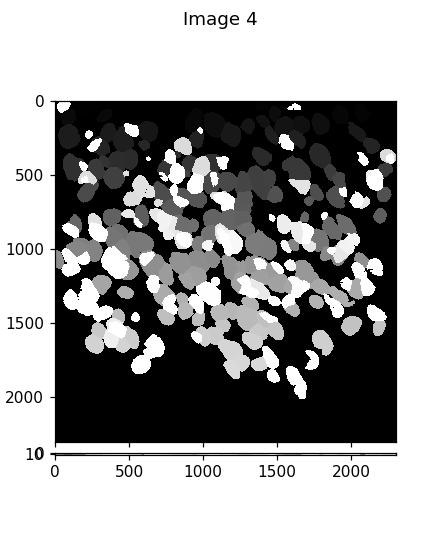

In [13]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [22]:
fiducial_channel

'477'

In [23]:
watershed_th = 1.4

for _fov_id, _fov_name in enumerate(fovs):
        
    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    

/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_0.npy already exists, skip
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_1.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_001.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_001_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.727s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction fo

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_4.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_004.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_004.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_004.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_004_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.864s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 40

- Loaded images for channels:['477', '405'] in 1.997s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.845s.
-- corrected illumination for channel 405 in 0.816s.
- Finished illumination correction in 1.684s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_007.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_007_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.023s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.851s.
-- corrected illumination for channel 405 in 0.820s.
- Finished illumination correction in 1.695s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_010.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_010_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.023s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.852s.
-- corrected illumination for channel 477 in 0.818s.
- Finished illumination correction in 1.693s.
+ Calcula

- Loaded images for channels:['637', '477'] in 0.952s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.813s.
-- corrected illumination for channel 477 in 0.810s.
- Finished illumination correction in 1.644s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   5.14 7.08] in 0.428s.
-- drift 1: [-0.01  5.06  7.64] in 0.448s.
-- drift 2: [-0.01  5.12  7.61] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.968s.
- Finished warp correction in 8.968s.
- r

-- corrected illumination for channel 637 in 0.818s.
-- corrected illumination for channel 477 in 0.810s.
- Finished illumination correction in 1.649s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.26  7.54] in 0.432s.
-- drift 1: [-0.04  4.26  7.33] in 0.445s.
-- drift 2: [-0.02  4.2   7.45] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.014s.
- Finished warp correction in 9.015s.
- run watershed in 173.139s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_16.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_17.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/C

-- drift 0: [-0.03  3.52  8.2 ] in 0.435s.
-- drift 1: [-0.01  3.3   7.95] in 0.465s.
-- drift 2: [-0.02  3.32  8.2 ] in 0.473s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.977s.
- Finished warp correction in 8.977s.
- run watershed in 217.101s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_19.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_20.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_020.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_020.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_020.dax
- New save 

-- corrected warp for channel 637 in 9.182s.
- Finished warp correction in 9.182s.
- run watershed in 183.793s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_22.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_23.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_023.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_023.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_023.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_023_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.724s.
- Correct illumination for channe

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_26.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_026.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_026.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_026.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_026_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.682s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 4

- Loaded images for channels:['477', '405'] in 1.977s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.847s.
-- corrected illumination for channel 405 in 0.818s.
- Finished illumination correction in 1.690s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_029.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_029_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.084s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.845s.
-- corrected illumination for channel 405 in 0.815s.
- Finished illumination correction in 1.684s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_032.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_032_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.125s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.847s.
-- corrected illumination for channel 477 in 0.814s.
- Finished illumination correction in 1.684s.
+ Calcula

- Loaded images for channels:['637', '477'] in 1.056s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.859s.
-- corrected illumination for channel 477 in 0.832s.
- Finished illumination correction in 1.718s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   4.83 9.87] in 0.413s.
-- drift 1: [-0.01  4.65  9.84] in 0.480s.
-- drift 2: [-0.01  4.7   9.92] in 0.462s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.954s.
- Finished warp correction in 8.954s.
- r

-- corrected illumination for channel 637 in 0.831s.
-- corrected illumination for channel 477 in 0.814s.
- Finished illumination correction in 1.667s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   4.77 8.19] in 0.412s.
-- drift 1: [-0.01  4.64  8.06] in 0.456s.
-- drift 2: [-0.01  4.62  8.18] in 0.440s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.932s.
- Finished warp correction in 8.933s.
- run watershed in 235.079s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_38.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_39.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv

-- drift 0: [-0.02  3.9   9.27] in 0.434s.
-- drift 1: [-0.01  3.81  9.14] in 0.452s.
-- drift 2: [-0.01  3.75  9.27] in 0.458s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.954s.
- Finished warp correction in 8.955s.
- run watershed in 186.658s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_41.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_42.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_042.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_042.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_042.dax
- New save 

-- drift 0: [0.01 4.4  8.71] in 0.428s.
-- drift 1: [-0.01  4.41  8.81] in 0.454s.
-- drift 2: [-0.02  4.12  8.77] in 0.461s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.932s.
- Finished warp correction in 8.932s.
- run watershed in 150.754s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_44.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_45.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_045.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_045.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_045.dax
- New save fil

-- drift 5: [0.   3.79 8.17] in 0.454s.
-- drift 6: [0.   3.87 8.07] in 0.454s.
-- drift 7: [0.   3.78 8.1 ] in 0.464s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.933s.
- Finished warp correction in 8.933s.
- run watershed in 144.917s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_47.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_48.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_048.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_048.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_048.dax
- New save file: /lab/weissman_imaging/puzheng/4T1

-- drift 1: [-0.02  4.35 10.36] in 0.453s.
-- drift 2: [-0.07  4.22 10.74] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.493s.
- Finished warp correction in 9.493s.
- run watershed in 95.873s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_50.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_51.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_051.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_051.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_051.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor

-- corrected warp for channel 637 in 8.920s.
- Finished warp correction in 8.920s.
- run watershed in 164.965s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_53.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_54.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_054.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_054.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_054.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_054_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.840s.
- Correct illumination for channe

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_57.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_057.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_057.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_057.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_057_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.849s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 4

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_61.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_061.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_061.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_061.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_061_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.730s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 4

- Loaded images for channels:['477', '405'] in 1.712s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.848s.
-- corrected illumination for channel 405 in 0.815s.
- Finished illumination correction in 1.688s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_064.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_064_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.989s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.846s.
-- corrected illumination for channel 405 in 0.819s.
- Finished illumination correction in 1.689s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_067.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_067_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.022s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.846s.
-- corrected illumination for channel 477 in 0.816s.
- Finished illumination correction in 1.685s.
+ Calcula

- Loaded images for channels:['637', '477'] in 1.156s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.828s.
-- corrected illumination for channel 477 in 0.825s.
- Finished illumination correction in 1.686s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  6.06  9.38] in 0.432s.
-- drift 1: [0.   5.87 9.14] in 0.448s.
-- drift 2: [-0.01  5.79  9.2 ] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.997s.
- Finished warp correction in 8.997s.
- r

-- corrected illumination for channel 637 in 0.860s.
-- corrected illumination for channel 477 in 0.824s.
- Finished illumination correction in 1.707s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.03 10.51] in 0.433s.
-- drift 1: [-1.000e-02  3.890e+00  1.039e+01] in 0.454s.
-- drift 2: [-1.000e-02  4.000e+00  1.044e+01] in 0.457s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.958s.
- Finished warp correction in 8.959s.
- run watershed in 187.367s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_73.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_74.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/2

-- drift 0: [-0.02  4.22  8.75] in 0.436s.
-- drift 1: [-0.03  4.48  8.68] in 0.455s.
-- drift 2: [-0.02  4.5   8.76] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.949s.
- Finished warp correction in 8.949s.
- run watershed in 196.268s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_76.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_77.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_077.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_077.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_077.dax
- New save 

-- corrected warp for channel 637 in 8.977s.
- Finished warp correction in 8.977s.
- run watershed in 165.569s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_79.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_80.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_080.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_080.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_080.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_080_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.834s.
- Correct illumination for channe

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_83.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_083.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_083.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_083.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_083_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.933s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 4

- Loaded images for channels:['477', '405'] in 1.787s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.848s.
-- corrected illumination for channel 405 in 0.822s.
- Finished illumination correction in 1.696s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_086.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_086_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.031s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.843s.
-- corrected illumination for channel 405 in 0.816s.
- Finished illumination correction in 1.684s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_089.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_089_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.061s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.846s.
-- corrected illumination for channel 477 in 0.818s.
- Finished illumination correction in 1.688s.
+ Calcula

-- corrected illumination for channel 477 in 0.844s.
-- corrected illumination for channel 405 in 0.817s.
- Finished illumination correction in 1.685s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_092.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_092_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.095s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.849s.
-- corrected illumination for channel 477 in 0.832s.
- Finished illumination correction in 1.705s.
+ Calcula

- Loaded images for channels:['637', '477'] in 1.102s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.905s.
-- corrected illumination for channel 477 in 0.824s.
- Finished illumination correction in 1.753s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.68 10.44] in 0.442s.
-- drift 1: [-1.000e-02  4.590e+00  1.033e+01] in 0.451s.
-- drift 2: [-0.02  4.48 10.47] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.842s.
- Finished warp correct

-- corrected illumination for channel 637 in 0.851s.
-- corrected illumination for channel 477 in 0.822s.
- Finished illumination correction in 1.696s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  3.54  9.36] in 0.441s.
-- drift 1: [0.   3.39 9.37] in 0.460s.
-- drift 2: [-0.02  3.31  9.63] in 0.451s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.800s.
- Finished warp correction in 8.800s.
- run watershed in 148.077s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_98.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_99.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv

-- drift 0: [-1.000e-02  3.250e+00  1.096e+01] in 0.457s.
-- drift 1: [-1.000e-02  3.140e+00  1.093e+01] in 0.477s.
-- drift 2: [-0.03  3.05 10.88] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.890s.
- Finished warp correction in 8.890s.
- run watershed in 157.379s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_101.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_102.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_102.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_102.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M

-- corrected warp for channel 637 in 9.158s.
- Finished warp correction in 9.158s.
- run watershed in 153.904s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_104.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_105.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_105.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_105.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_105.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_105_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.791s.
- Correct illumination for chan

reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_111.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_111.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_111.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_111_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.693s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.852s.
-- corrected illumination for c

- Loaded images for channels:['477', '405'] in 1.862s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 1.020s.
-- corrected illumination for channel 405 in 0.914s.
- Finished illumination correction in 1.966s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_114.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_114_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.085s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.843s.
-- corrected illumination for channel 405 in 0.814s.
- Finished illumination correction in 1.683s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_117.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_117_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.945s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.845s.
-- corrected illumination for channel 477 in 0.813s.
- Finished illumination correction in 1.681s.
+ Calcula

- Loaded images for channels:['637', '477'] in 1.030s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.854s.
-- corrected illumination for channel 477 in 0.822s.
- Finished illumination correction in 1.713s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  4.83 11.59] in 0.434s.
-- drift 1: [-3.1   0.05  0.01] in 0.453s.
-- drift 2: [-1.000e-02  4.710e+00  1.169e+01] in 0.454s.
-- drift 3: [-1.000e-02  4.820e+00  1.151e+01] in 0.452s.
-- drift 4: [-1.000e-02  4.700e+00  1.161e+01] in 0.457s.
-- drift 5: [-1.000e-02  4.720e+00  1.142e+01] in 0.459s.
-- drift 6: [-0.05  4.78 11.56] in 0.461s.
-- dr

- Loaded images for channels:['637', '477'] in 1.044s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.848s.
-- corrected illumination for channel 477 in 0.816s.
- Finished illumination correction in 1.687s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    3.59 10.33] in 0.437s.
-- drift 1: [-1.000e-02  3.310e+00  1.043e+01] in 0.480s.
-- drift 2: [-1.000e-02  3.320e+00  1.047e+01] in 0.475s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.076s.
- Finish

-- corrected illumination for channel 637 in 0.850s.
-- corrected illumination for channel 477 in 0.823s.
- Finished illumination correction in 1.697s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  2.99  9.85] in 0.429s.
-- drift 1: [0.  2.9 9.8] in 0.460s.
-- drift 2: [0.   2.91 9.73] in 0.460s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.909s.
- Finished warp correction in 8.909s.
- run watershed in 211.833s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_126.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_127.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zsc

-- drift 0: [-1.000e-02  3.840e+00  1.014e+01] in 0.470s.
-- drift 1: [-1.00e-02  3.88e+00  1.01e+01] in 0.470s.
-- drift 2: [-0.01  3.83  9.95] in 0.468s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 9.063s.
- Finished warp correction in 9.063s.
- run watershed in 250.592s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_129.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_130.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_130.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_130.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/C

-- corrected warp for channel 637 in 8.925s.
- Finished warp correction in 8.925s.
- run watershed in 228.294s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_132.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_133.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_133.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_133.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_133.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_133_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.880s.
- Correct illumination for chan

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_136.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_136.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_136.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_136.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_136_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.101s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 

- Loaded images for channels:['477', '405'] in 1.862s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.836s.
-- corrected illumination for channel 405 in 0.825s.
- Finished illumination correction in 1.685s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_139.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_139_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.978s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination

-- corrected illumination for channel 477 in 0.844s.
-- corrected illumination for channel 405 in 0.813s.
- Finished illumination correction in 1.682s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_142.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_142_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.086s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.845s.
-- corrected illumination for channel 477 in 0.814s.
- Finished illumination correction in 1.681s.
+ Calcula

- Loaded images for channels:['637', '477'] in 1.123s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.834s.
-- corrected illumination for channel 477 in 0.804s.
- Finished illumination correction in 1.661s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  3.370e+00  1.056e+01] in 0.410s.
-- drift 1: [ 0.    3.28 10.36] in 0.426s.
-- drift 2: [-1.000e-02  3.300e+00  1.044e+01] in 0.440s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.890s.
- Finish

-- corrected illumination for channel 637 in 0.850s.
-- corrected illumination for channel 477 in 0.820s.
- Finished illumination correction in 1.693s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    3.45 10.1 ] in 0.409s.
-- drift 1: [ 0.    3.35 10.08] in 0.469s.
-- drift 2: [ 0.    3.3  10.13] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.886s.
- Finished warp correction in 8.886s.
- run watershed in 156.433s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_148.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_149.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1

-- drift 0: [-0.03  3.8  10.43] in 0.434s.
-- drift 1: [-0.02  3.62 10.37] in 0.449s.
-- drift 2: [-1.000e-02  3.700e+00  1.043e+01] in 0.448s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.877s.
- Finished warp correction in 8.877s.
- run watershed in 197.534s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_151.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_152.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_152.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_152.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_15

-- corrected warp for channel 637 in 9.272s.
- Finished warp correction in 9.272s.
- run watershed in 188.461s.
- save to file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/watershed/segmentation_label_154.npy
- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/Segmentation/segmentation_label_155.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_155.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_155.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_155.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H0M1/Conv_zscan_155_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.714s.
- Correct illumination for chan

-- corrected illumination for channel 477 in 0.850s.
-- corrected illumination for channel 405 in 0.823s.
- Finished illumination correction in 1.700s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_174.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240423-F242depc_MF4dna/H8M9/Conv_zscan_174_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.009s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.851s.
-- corrected illumination for channel 477 in 0.823s.
- Finished illumination correction in 1.697s.
+ Calcula

- Loaded images for channels:['637', '477'] in 0.943s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.859s.
-- corrected illumination for channel 477 in 0.820s.
- Finished illumination correction in 1.702s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  3.110e+00  1.016e+01] in 0.434s.
-- drift 1: [0.   2.98 9.99] in 0.466s.
-- drift 2: [ 0.    2.99 10.09] in 0.456s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.892s.
- Finished warp correction

In [33]:
waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
imshow_mark_3d([polyt_im])

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


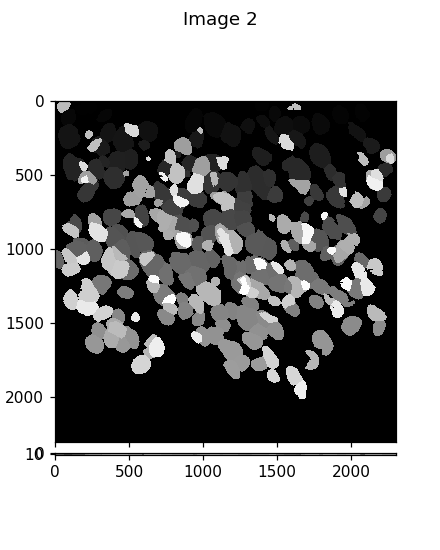

In [17]:
imshow_mark_3d([new_labels, corr_labels3d])

In [34]:
## Manually load one field of view and visualize:
sel_fov_id = 31
fov_segmentation_filename = os.path.join(segmentation_save_folder, f'segmentation_label_{sel_fov_id}.npy')
fov_segmentation = np.load(fov_segmentation_filename)
fov_watershed_filename = os.path.join(watershed_folder, f'segmentation_label_{sel_fov_id}.npy')
fov_watershed = np.load(fov_watershed_filename)

<IPython.core.display.Javascript object>


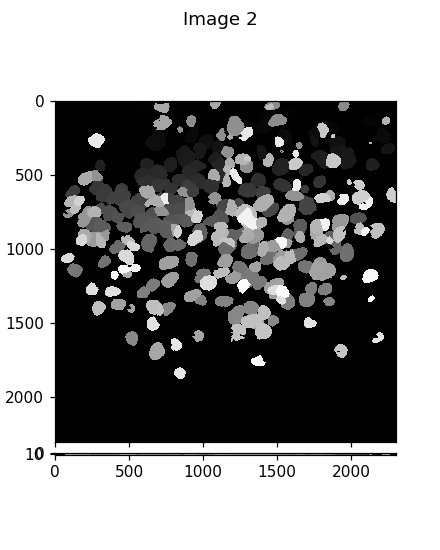

In [35]:
imshow_mark_3d([fov_watershed, fov_segmentation, ])

In [37]:
test_segmentation = np.load(r'/lab/solexa_weissman/puzheng/MERFISH_analysis/20240423-4T1F242_MF4dna/CellPoseSegment/segmentation_label/segmentation_label_31.npy')


<IPython.core.display.Javascript object>


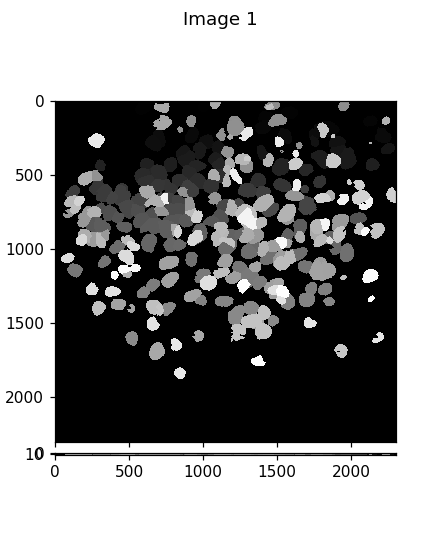

In [38]:
imshow_mark_3d([test_segmentation])

# Copy segmentation labels

In [28]:
# Copy segmentation labels
from shutil import copyfile
data_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

['20240423-4T1F242_MF4dna', 'SequencingRef', '.DS_Store', '2023_WB_data', '2021_Meng_data']
20240423
/lab/solexa_weissman/puzheng/MERFISH_analysis/20240423-4T1F242_MF4dna


In [29]:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
segmentation_source_folder = segmentation_save_folder
seg_label_filenames = [os.path.join(segmentation_source_folder, _f) 
                       for _f in os.listdir(segmentation_source_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/solexa_weissman/puzheng/MERFISH_analysis/20240423-4T1F242_MF4dna/CellPoseSegment/segmentation_label
segmentation_label_58.npy
segmentation_label_0.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_7.npy
segmentation_label_8.npy
segmentation_label_9.npy
segmentation_label_10.npy
segmentation_label_11.npy
segmentation_label_12.npy
segmentation_label_13.npy
segmentation_label_14.npy
segmentation_label_15.npy
segmentation_label_16.npy
segmentation_label_17.npy
segmentation_label_18.npy
segmentation_label_19.npy
segmentation_label_20.npy
segmentation_label_21.npy
segmentation_label_22.npy
segmentation_label_23.npy
segmentation_label_24.npy
segmentation_label_25.npy
segmentation_label_26.npy
segmentation_label_27.npy
segmentation_label_28.npy
segmentation_label_29.npy
segmentation_label_30.npy
segmentation_label_31.npy
segmentation_label_32.npy
segmentation_label_33

In [30]:
len(seg_label_filenames)

221

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')